# Functions and Imports for Ovarian Cancer Ratio Analysis

In [5]:
import pandas as pd
import numpy as np
import scipy.stats
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
ov = cptac.Ovarian()
colon = cptac.Colon()
en = cptac.Endometrial()

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******
Checking that data files are up-to-date...

Data check complete.
ovarian data version: Most recent release

Loading clinical data...
Loading cnv data...
Loading definitions data...
Loading phosphoproteomics data...
Loading proteomics data...
Loading somatic_38 data...
Loading transcriptomics data...
Loading treatment data...
Checking that data files are up-to-date...

Data check complete.
colon data version: Most recent release

Loading clinical data...
Loading miRNA data...
Loading mutation data...
Loading mutation_binary data...
Loading phosphoproteomics_normal data...
Loading phosphoproteomics_tumor data...
Loading proteomics_normal data...
Loading proteomics_tumor data...
Loading transcriptomics data...
Checking that data files are u

### Import patient data as well as a list of protein complexes from CORUM (http://mips.helmholtz-muenchen.de/corum/#download 'Complete Complexes')

In [6]:
data = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/OvarianProspective/Protein_Complexes/Data_Files/proteinGroups_cleaned.txt', sep='\t')
ov_clinical = ov.get_clinical()
ov_mutations = ov.get_mutations()
colon_clinical = colon.get_clinical()
colon_mutations = colon.get_mutations()
en_clinical = en.get_clinical()
en_mutations = en.get_mutations()

# Remove duplicate rows from the dataset
data = data.set_index('Gene_Name')
data = data.loc[~data.index.duplicated()]
complexData = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/OvarianProspective/Protein_Complexes/Data_Files/allComplexes.txt', sep='\t')

### Import transcriptional regulatory interactions from TRRUST v2 (https://www.grnpedia.org/trrust/downloadnetwork.php) and mutation data for tumor samples

In [7]:
ov_mutation_data = ov_clinical[['Patient_ID', 'Sample_Tumor_Normal']].join(ov_mutations).dropna(axis = 0)
ov_mutation_data = ov_mutation_data.loc[ov_mutation_data['Sample_Tumor_Normal'] == 'Tumor']

colon_mutation_data = colon_clinical[['Patient_ID', 'Sample_Tumor_Normal']].join(colon_mutations).dropna(axis = 0)
colon_mutation_data = colon_mutation_data.loc[colon_mutation_data['Sample_Tumor_Normal'] == 'Tumor']

en_mutation_data = en_clinical[['Patient_ID', 'Proteomics_Tumor_Normal']].join(en_mutations).dropna(axis = 0)
en_mutation_data = en_mutation_data.loc[en_mutation_data['Proteomics_Tumor_Normal'] == 'Tumor']

tf_data = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/OvarianProspective/Protein_Complexes/Data_Files/trrust_rawdata.human.tsv', sep='\t', header=None)
tf_data.columns = ['TF', 'Regulated_Gene', 'Regulation_Type', 'ID']

### Create a workable dictionary of protein complex information

In [8]:
# Select for human complexes
complexData = complexData.loc[complexData['Organism'] == 'Human']

# Split the proteins in each complex into invdividual columns of a new df
subunitNames = complexData['subunits(Gene name)'].str.split(';', expand = True)
subunitNames.index = complexData.ComplexName

# Create a dictionary (key = complex name, value = list of proteins in complex) and remove None values
subunitNames = subunitNames.loc[~subunitNames.index.duplicated()]
subunitNames = subunitNames.transpose().to_dict('list')
for key, val in subunitNames.items():
    subunitNames[key] = [value for value in val if value != None]

## Define basic analysis and plotting functions

### get_ratio_df

In [9]:
"""
get_ratio_df
-----------
All patients, single protein, tumor vs normal
Returns two dataframes: tumor and normal containing ratios for the proteins

Parameters:
    prot1, prot2 = (gene) names of the two proteins to be compared (ratio of prot1 / prot2)
    
Returns:
    Two dataframes: tumor and normal containing ratios for the proteins
  
"""
def get_ratio_df(prot1, prot2):
    # Make sure that both proteins are in our dataset
    if not data.index.contains(prot1) or not data.index.contains(prot2): return None, None
    
    # Create a dataframe of ratios for easy testing
    tumor_rows_list = []
    normal_rows_list = []
    for patient in data.columns:
        
        # Determine the sample type
        sample_type = 'Tumor'
        if '_NM' in patient: sample_type = 'Normal'
            
        # Find the ratio prot1 / prot2 and create a new row for the dataframe
        if data.at[prot2, patient] == 0: 
            ratio = np.nan
        else: 
            ratio = data.at[prot1, patient] / data.at[prot2, patient]
        # Create a row entry for the dictionary
        row_dict = {'Ratio': ratio, 'Sample_Type': sample_type, 'Patient_ID': patient}
        
        # Add the new row to the tumor or normal list, depending on the sample type
        if sample_type == 'Tumor':
            tumor_rows_list.append(row_dict)
        else:
            normal_rows_list.append(row_dict)
    
    # Convert the row lists into dataframes
    tumor_ratio_df = pd.DataFrame(tumor_rows_list)
    normal_ratio_df = pd.DataFrame(normal_rows_list)
    
    # If there were no valid ratios for either the tumor or normal samples, return None
    if (not np.isfinite(tumor_ratio_df['Ratio']).any()) or (not np.isfinite(normal_ratio_df['Ratio']).any()): 
        return None, None
    
    # Drop na values
    tumor_ratio_df = tumor_ratio_df.dropna(axis = 0)
    normal_ratio_df = normal_ratio_df.dropna(axis = 0)
    
    return tumor_ratio_df, normal_ratio_df

In [41]:
prot_list = ['UPF1', 'UPF2', 'UPF3B', 'DCP2', 'XRN1', 'XRN2', 'EXOSC2', 'EXOSC4', 'EXOSC10', 'PARN']

UPF1
T-test p-value: 1.5433324624837267e-06
Levene p-value: 0.7238882463990002
UPF2
T-test p-value: 4.300099555635939e-06
Levene p-value: 0.17901136722751784
UPF3B
T-test p-value: 0.025387267113272483
Levene p-value: 0.6841307243766255
DCP2
T-test p-value: 0.13776058700192964
Levene p-value: 0.24303468248675936
XRN1
T-test p-value: 0.06301982576620656
Levene p-value: 0.5398318084487133
XRN2
T-test p-value: 1.7835142355327793e-08
Levene p-value: 0.15205130383735022
EXOSC2
T-test p-value: 0.06275986620369364
Levene p-value: 0.4144627348194494
EXOSC4
T-test p-value: 0.00023508996961818691
Levene p-value: 0.6728105328142916
EXOSC10
T-test p-value: 0.3317899130491755
Levene p-value: 0.43935926564671957
PARN
T-test p-value: 0.03862314480564833
Levene p-value: 0.3500026670278841


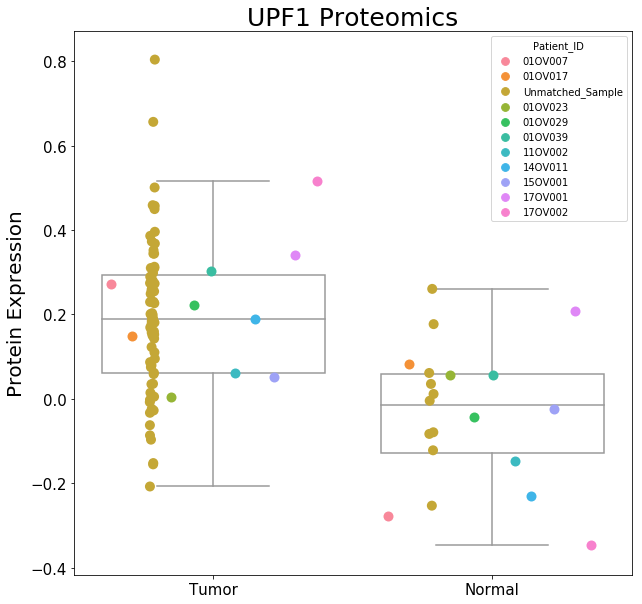

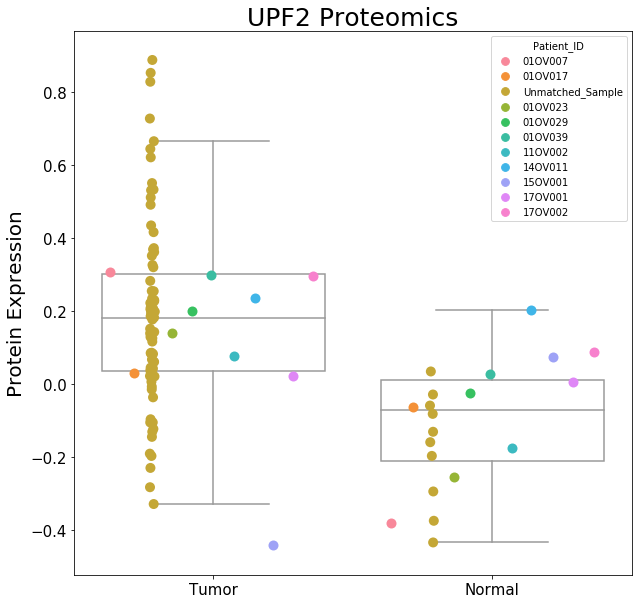

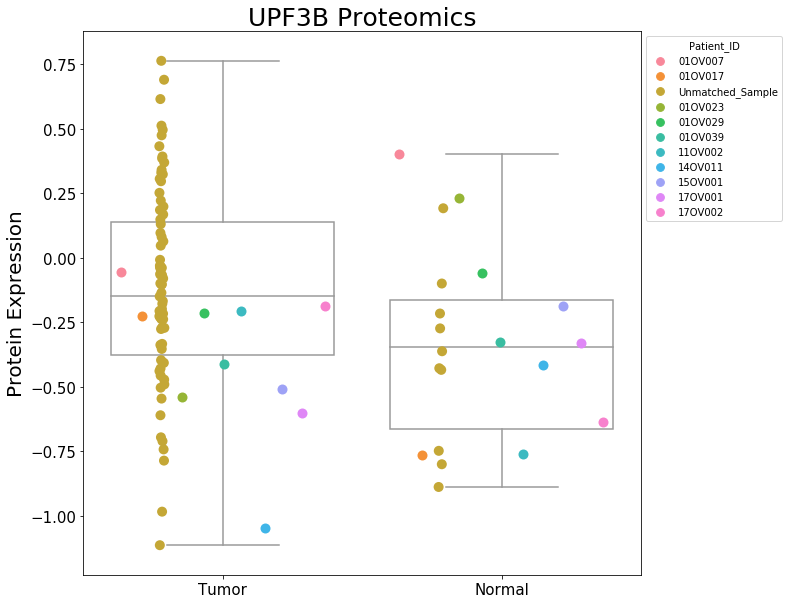

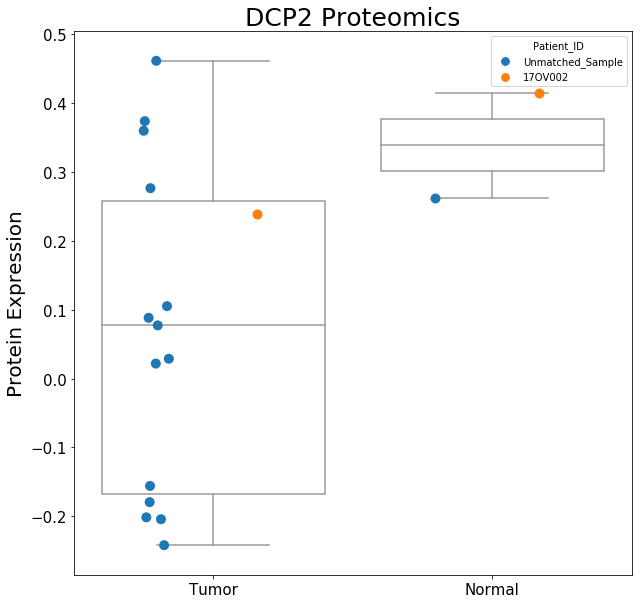

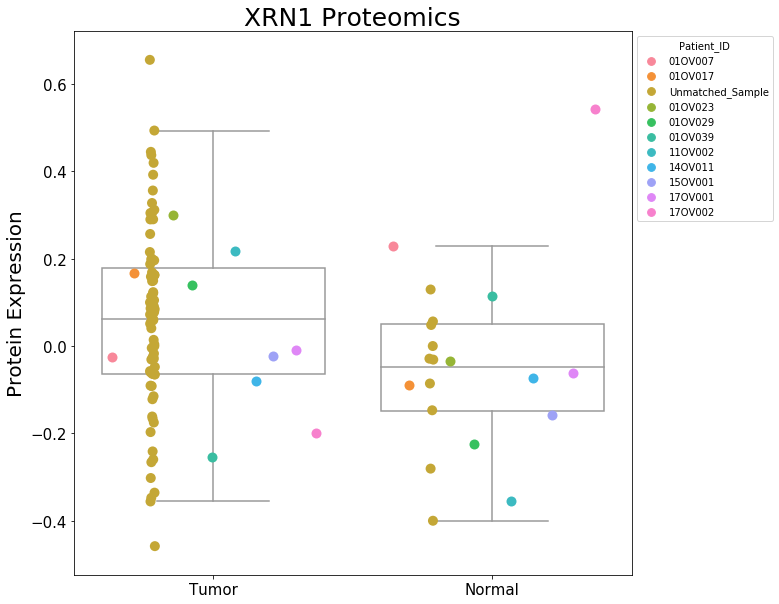

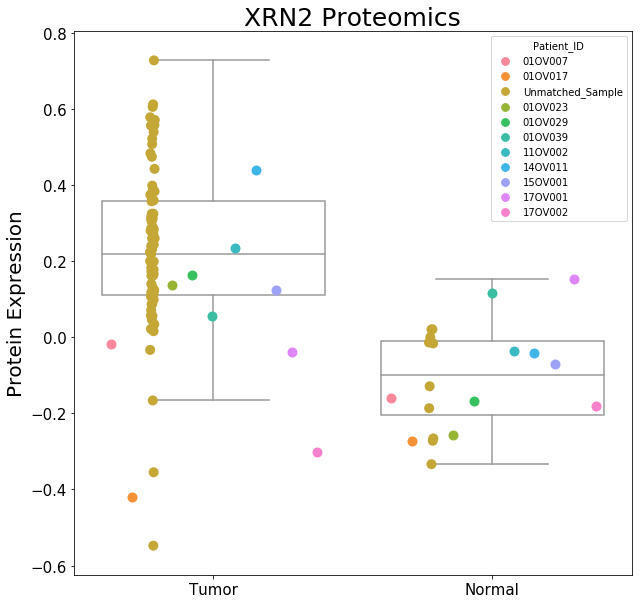

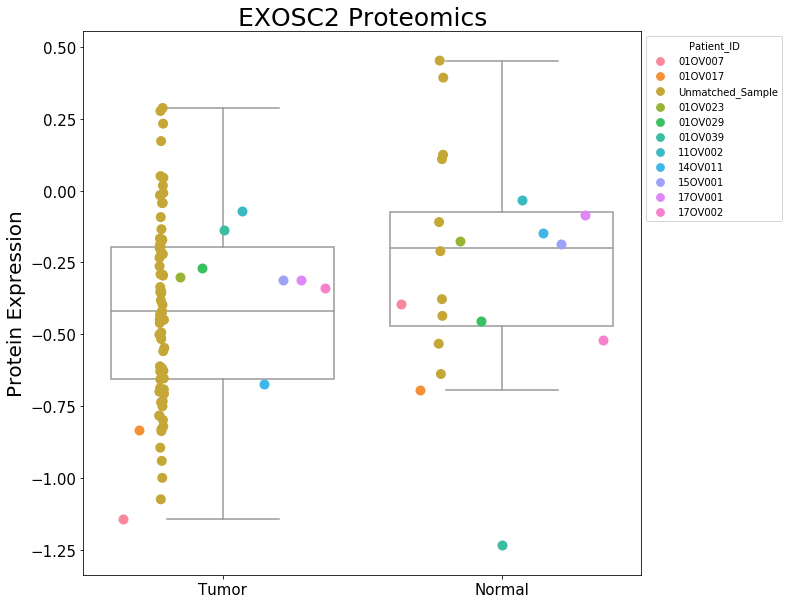

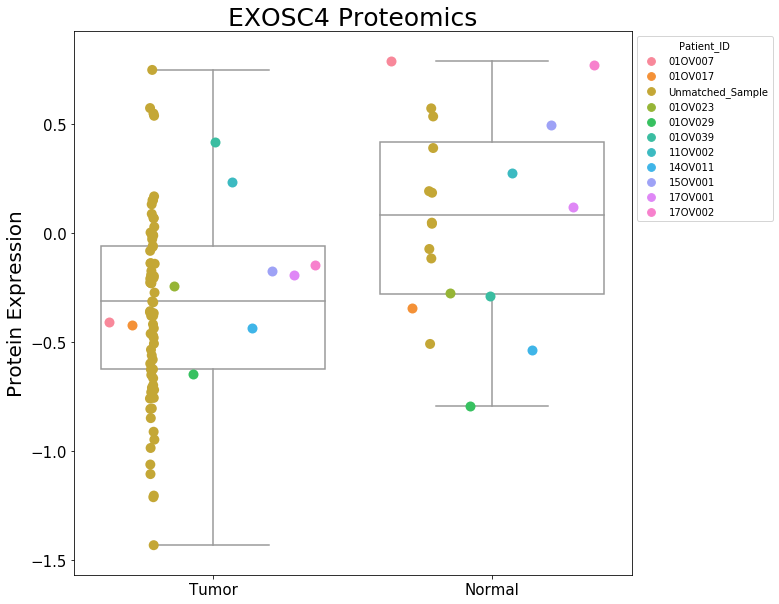

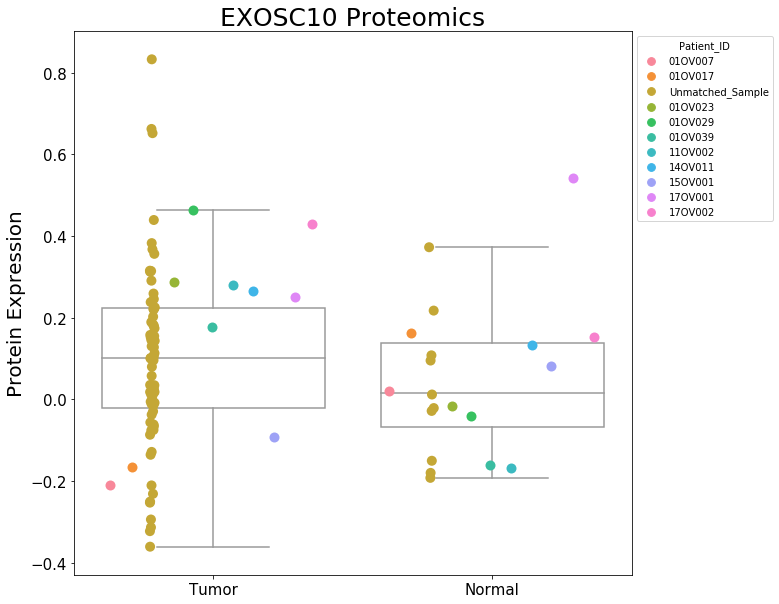

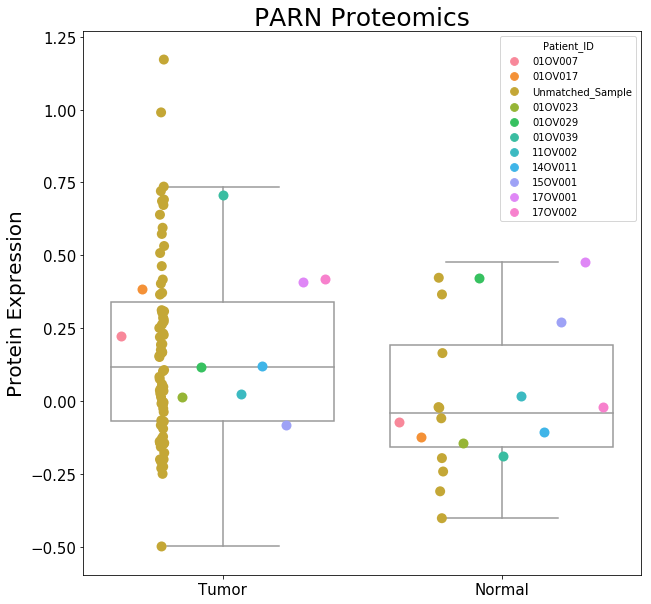

In [42]:
for protein in prot_list:
    print(protein)
    plot_proteomics(protein, by_patient = True)

In [35]:
df = en.get_derived_molecular()
df['Genomics_subtype']

Sample_ID
S001       MSI-H
S002       MSI-H
S003     CNV_low
S005     CNV_low
S006    CNV_high
S007     CNV_low
S008     CNV_low
S009    CNV_high
S010       MSI-H
S011     CNV_low
S012        POLE
S014       MSI-H
S016    CNV_high
S017       MSI-H
S018    CNV_high
S019     CNV_low
S020     CNV_low
S021     CNV_low
S022        POLE
S023        POLE
S024     CNV_low
S025     CNV_low
S026     CNV_low
S027        POLE
S028     CNV_low
S029     CNV_low
S030       MSI-H
S031    CNV_high
S032       MSI-H
S033     CNV_low
          ...   
S124         NaN
S125         NaN
S126         NaN
S127         NaN
S128         NaN
S129         NaN
S130         NaN
S131         NaN
S132         NaN
S133         NaN
S134         NaN
S135         NaN
S136         NaN
S137         NaN
S138         NaN
S139         NaN
S140         NaN
S141         NaN
S142         NaN
S143         NaN
S144         NaN
S145         NaN
S146         NaN
S147         NaN
S148         NaN
S149         NaN
S150         NaN
S151

### test_complex

In [10]:
"""
test_complex
------------
Perform statistical tests on every combination of proteins in a given complex, printing those with significant p-values

Parameters:
    complex_name = name of the complex
    test_type = type of test to perform, levene or ttest
    
Returns:
    Classification of the complex: whether it has proteins missing in the normal, missing proteins in cancer,
    or other (proteins present in both)
    Prints tests with statistically significant values

"""
def test_complex(complex_name, test_type = 'ttest'):
    
    prot_list = subunitNames[complex_name]
    sig_result_found = False
    
    # Keep track of how many significant ratios in this complex include only 0 values for tumor/normal 
    num_missing_tumor = 0
    num_missing_normal = 0
    
    # Calculate the cutoff for significance (Bonferroni correction)
    alpha = 0.05 / (len(subunitNames)*(len(subunitNames) - 1))
    
    for i in range(0, len(prot_list)):
        for j in range(0, len(prot_list)):
            if j == i: continue
                
            # Test the two proteins (ratio of prot1 / prot2)
            tumor_ratio_df, normal_ratio_df = get_ratio_df(prot_list[i], prot_list[j])
            if tumor_ratio_df is None or normal_ratio_df is None: continue

            # Perform the selected statistical test on the ratios
            
            # If both tumor and normal only have 0 values for the ratio, the tests don't work
            if (sum(tumor_ratio_df['Ratio']) == 0) and (sum(normal_ratio_df['Ratio']) == 0): continue   
            # If there are not enough samples, the tests also don't work
            if (len(tumor_ratio_df) < 2) or (len(normal_ratio_df) < 2): continue
                
            if test_type == 'ttest':
                test_result = scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            else:
                # This test throws a warning if the variance in both is 0, so we check for that
                if (np.var(tumor_ratio_df['Ratio']) == 0) and (np.var(normal_ratio_df['Ratio']) == 0): continue
                test_result = scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            
            # If the p-value is significant, print the result and return the appropriate classification
            if test_result < alpha:
                sig_result_found = True
                # Determine the classification of this ratio
                if not (normal_ratio_df['Ratio'] != 0).any():
                    num_missing_normal += 1
                    print('Normal missing ' + prot_list[i] + ' / ' + prot_list[j])
                elif not (tumor_ratio_df['Ratio'] != 0).any():
                    num_missing_tumor += 1
                    print('Tumor missing ' + prot_list[i] + ' / ' + prot_list[j])
    
                print(prot_list[i] + ' / ' + prot_list[j] + ': ' + str(test_result))
                
    if sig_result_found: 
        
        print(complex_name)
        print('---------------------------')
        print('---------------------------')
        
        # Classify the complex as a whole depending on the classification of the majority of ratios
        # If none of the ratios had all 0 values for tumor or normal, it is classified as "Other"
        if num_missing_normal == 0 and num_missing_tumor == 0:
            return "Other"
        elif num_missing_normal >= num_missing_tumor:
            return "Normal Missing Proteins"
        elif num_missing_tumor > num_missing_normal:
            return "Tumor Missing Proteins"
        
    return "NS"

### test_all_complexes

In [11]:
"""
test_all_complexes
------------------
Test all complexes in the dataset for significance

Parameters:
    test_type (optional) = ttest or levene
    
Returns:
    A dictionary: {"Normal Missing Proteins": [List of complexes], 
    "Tumor Missing Proteins": [List of complexes], 
    "Other": [List of complexes]}
    
"""

def test_all_complexes(test_type = 'ttest'):
    
    if test_type != 'ttest' and test_type != 'levene':
        print("Error: test_type must equal 'ttest' or 'levene'")
        return
    
    classified_complexes = {"Normal Missing Proteins": [], "Tumor Missing Proteins": [], "Other": [], "NS": []}
    
    for key, val in subunitNames.items():
        complex_type = test_complex(key, test_type = test_type)
        classified_complexes[complex_type].append(key)
        
    return classified_complexes

### find_mutations

In [12]:
"""
find_mutations
--------------
Search mutational data for mutations in proteins that change in a complex or transcription factors
known to regulate said proteins

Parameters:
    complex_dict = dictionary of protein complexes (output of test_all_complexes)
    transcription_factors = if True, will test for mutations in transcription factors known to regulate
        proteins in the complex
        
Returns:
    Prints results (how many patients have mutations in the protein or transcription factor)

"""

def find_mutations(complex_dict, transcription_factors = False):
    
    for key, val in complex_dict.items():
        if key == 'NS': continue
        print(key)
        print('--------------')
        print('--------------')
        for complex_name in val:
            changed_proteins = []
            mutation_rate = {}

            # Calculate the cutoff for significance (Bonferroni correction)
            alpha = 0.05 / (len(subunitNames)*(len(subunitNames) - 1))

            # Perform tests to find statistically significant differences in ratios
            protein_list = subunitNames[complex_name]
            for prot1 in protein_list:
                for prot2 in protein_list:
                    if prot1 == prot2: continue

                    # Test the two proteins (ratio of prot1 / prot2)
                    tumor_ratio_df, normal_ratio_df = get_ratio_df(prot1, prot2)
                    if tumor_ratio_df is None or normal_ratio_df is None: continue

                    # Perform the selected statistical tests on the ratios
                    
                    # If both tumor and normal only have 0 values for the ratio, the tests don't work
                    if (sum(tumor_ratio_df['Ratio']) == 0) and (sum(normal_ratio_df['Ratio']) == 0): continue
                    # If there are not enough samples, the tests also don't work
                    if (len(tumor_ratio_df) < 2) or (len(normal_ratio_df) < 2): continue
                
                    ttest_result = scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
                    # The levene test throws a warning if the variance in both is 0, so we check for that
                    if (np.var(tumor_ratio_df['Ratio']) != 0) and (np.var(normal_ratio_df['Ratio']) != 0):
                        levene_result = scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
                    else:
                        levene_result = 1

                    # If the p-value is significant, add the numerator protein to changed_proteins
                    if ttest_result < alpha or levene_result < alpha:
                        changed_proteins.append(prot1)

            changed_proteins = list(set(changed_proteins))
            for protein in changed_proteins:
                if transcription_factors:
                    tfs = tf_data.loc[tf_data['Regulated_Gene'] == protein]['TF']
                    for tf in tfs:
                        num_mutations = len(set(mutation_data.loc[mutation_data['Gene'] == tf]['Patient_ID']))
                        tf_title = tf + ' (regulates ' + protein + ')'
                        if num_mutations > 0:
                            mutation_rate[tf_title] = num_mutations
                else:
                    num_mutations = len(set(mutation_data.loc[mutation_data['Gene'] == protein]['Patient_ID']))
                    if num_mutations > 0:
                        mutation_rate[protein] = num_mutations
            if len(mutation_rate) > 0:
                print(complex_name)
                print(mutation_rate)
                print('--------------')

### find_unique_mutations

In [13]:
"""
find_unique_mutations
---------------------
Find the number of patients with a mutation in any one of the proteins in a list

Parameters:
    prot_list = list of proteins to look for mutations in
    
Returns:
    prints the number of patients with a mutation in a protein in prot_list as well as their identifiers
    returns a list of those patients
"""

def find_unique_mutations(prot_list, cancer_type = 'ov'):
    # Set the cancer type
    if cancer_type == 'ov': mutation_data = ov_mutation_data
    elif cancer_type == 'colon': mutation_data = colon_mutation_data
    elif cancer_type == 'en': mutation_data = en_mutation_data
    else: print('Error: cancer_type must be "ov", "colon", or "en"')
        
    patients = []
    mutated_proteins = {}
    for protein in prot_list:
        mutations = list(mutation_data.loc[mutation_data['Gene'] == protein]['Patient_ID'])
        if len(mutations) > 0:
            mutated_proteins[protein] = len(mutations)
            patients = patients + mutations
    patients = list(set(patients))
    print('Patients with a mutation in any of the ' + str(len(prot_list)) + ' given proteins: ' + str(len(patients)) + '\n')
    print(mutated_proteins)
    return patients

### plot_ratios

In [14]:
"""
plot_ratios
-----------
Create a seaborn plot for the ratios in a dataframe

Parameters:
    prot1, prot2 = the two proteins to plot (ratio of prot1 / prot2)
    by_patient (optional) = T/F whether or not to visualize matched samples
    mutation_list (optional) = plot will distinguish patients with a mutation in any of the proteins in this list
    
Returns:
    Displays a plot of the data
    
"""
def plot_ratios(prot1, prot2, by_patient = False, mutation_list = None):
    
    # Set up dataframe for plotting
    tumor_ratio_df, normal_ratio_df = get_ratio_df(prot1, prot2)
    plot_data = tumor_ratio_df.append(normal_ratio_df)
    
    # Reformat for visualizing matched samples if necessary
    if by_patient or mutation_list:
        # Create a new column for matched status
        tumor_ratio_df['Matched_Status'] = 'Unmatched'
        normal_ratio_df['Matched_Status'] = 'Unmatched'
        # Classify samples as matched/unmatched
        normal_ratio_df.loc[((normal_ratio_df['Patient_ID']).str.replace('_NM', '')).isin(tumor_ratio_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        tumor_ratio_df.loc[((tumor_ratio_df['Patient_ID']) + '_NM').isin(normal_ratio_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        # Label samples accordingly in plot_data
        plot_data = tumor_ratio_df.append(normal_ratio_df)
        if mutation_list:
            # Find patients with mutations in the given proteins
            patient_list = find_unique_mutations(mutation_list)
            plot_data.loc[plot_data['Patient_ID'].isin(patient_list), 'Matched_Status'] = 'Has_Mutation'
        plot_data.loc[plot_data['Matched_Status'] == 'Unmatched', 'Patient_ID'] = 'Unmatched_Sample'
        plot_data['Patient_ID'] = plot_data['Patient_ID'].str.replace('_NM','')
    
    # Reformat for visualizing a certain list of patients if necessary
    if mutation_list and not by_patient:
        plot_data.loc[~plot_data['Patient_ID'].isin(patient_list), 'Patient_ID'] = 'Other Mutation'
        plot_data.loc[plot_data['Patient_ID'].isin(patient_list), 'Patient_ID'] = 'Given Mutation'
    elif mutation_list:
        plot_data.loc[plot_data['Patient_ID'].isin(patient_list), 'Patient_ID'] = 'Given Mutation'
        
    # Print results of statistical tests
    print('T-test p-value: ' + str(scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]))
    print('Levene p-value: ' + str(scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]))
    
    a4_dims = (10, 10)
    fig, ax = plt.subplots(figsize=a4_dims)

    # Create the plot
    if by_patient or patient_list:
        boxplt = sns.boxplot(data=plot_data, x='Sample_Type', y='Ratio', color='w', showfliers=False)
        boxplt = sns.stripplot(data=plot_data, x='Sample_Type', y='Ratio', hue='Patient_ID', size=10, dodge=True, jitter=True)
        boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))
    else:
        boxplt = sns.boxplot(data=plot_data, x='Sample_Type', y='Ratio', showfliers=False)
        boxplt = sns.stripplot(data=plot_data, x='Sample_Type', y='Ratio', dodge=True, jitter=True, color='.3')

    # Add styling
    boxplt.set_title('Ratio of ' + prot1 + ' / ' + prot2, fontsize='25')
    boxplt.set_xlabel('')
    boxplt.set_ylabel('Protein Expression Ratio', fontsize='20')
    boxplt.tick_params(labelsize='15')

### ttest_proteomics

In [15]:
"""
ttest_proteomics
----------------
Performs and prints a basic t-test on the proteomics of a given protein (tumor vs normal)

Parameters:
    protein = protein to test
    use_cptac (optional) = T/F whether to use the CPTAC proteomics data (default) or the non-normalized data
    
Returns:
    p-value of the t-test
"""

def ttest_proteomics(protein, use_cptac = True, cancer_type = 'ov'):
    
    # This uses the normalized proteomics data from the CPTAC package
    if use_cptac:
        # Get data from the appropriate cancer type
        if cancer_type == 'ov':
            test_data = ov.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'colon': 
            test_data = colon.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'en': 
            test_data = en.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Proteomics_Tumor_Normal'], 
                                                omics_genes = protein)
        else: print('Error: cancer_type must be "ov", "colon", or "en"')
            
        test_data = test_data.loc[:, ~test_data.columns.duplicated()]
        if cancer_type == 'en':
            test_data.rename(columns={protein+'_proteomics': protein, 'Proteomics_Tumor_Normal': 'Sample_Type'}, inplace = True)
            test_data.loc[test_data['Sample_Type'] != 'Tumor', 'Sample_Type'] = 'Normal'
        else:
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)
        tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
        normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
    
    # Otherwise use the non-normalized data to make the plot
    else:
        test_data = pd.DataFrame(data.loc[data.index == protein].transpose())
        test_data['Sample_Type'] = 'Tumor'
        test_data.loc[test_data.index.str.contains('_NM'), 'Sample_Type'] = 'Normal'

        tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor']
        normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal']
    
    # Perform the t-test
    return scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]

### find_differential_expression

In [22]:
"""
find_differential_expression
----------------------------
Searches through all the proteomic data and finds proteins with differential expression in tumor cells using t-tests.
Organizes results into categories: tumor lower and normal lower

Parameters:
    cancer_type = 'ov', 'en', or 'colon'; the cancer to search for
    
Returns:
    A dictionary of the form {tumor_lower: [list_of_proteins], normal_lower: [list_of_proteins]}
    'tumor_lower' means that there are lower expression levels of that protein in tumor samples
    
"""

def find_differential_expression(cancer_type = 'ov'):
    results = {'tumor_lower': [], 'normal_lower': []}
    
    # Get data from the appropriate cancer type
    if cancer_type == 'ov':
        alpha = 0.05 / len(ov.get_proteomics().columns)
        for protein in ov.get_proteomics().columns:
            test_data = ov.append_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
            
        
    elif cancer_type == 'colon': 
        alpha = 0.05 / len(colon.get_proteomics().columns)
        for protein in colon.get_proteomics().columns:
            test_data = colon.append_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
        
    elif cancer_type == 'en': 
        alpha = 0.05 / len(en.get_proteomics().columns)
        for protein in en.get_proteomics().columns:
            test_data = en.append_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Proteomics_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Proteomics_Tumor_Normal': 'Sample_Type'}, inplace = True)
            test_data.loc[test_data['Sample_Type'] != 'Tumor', 'Sample_Type'] = 'Normal'

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
        
    else: print('Error: cancer_type must be "ov", "colon", or "en"')
    
    return results
    

In [30]:
complexData

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name),Subunits comment,PubMed ID,Complex comment,Disease comment,SWISSPROT organism,subunits(Gene name syn),subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC4,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC5,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC7,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,B-cell lymphoma 6 protein;Histone deacetylase 7
3,4,Multisubunit ACTR coactivator complex,Human,None,None,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,MI:0004-affinity chromatography technologies;M...,GO:0045893;GO:0023052;GO:0005634,"positive regulation of transcription, DNA-temp...",11.02.03.04.01;30.01;70.10,transcription activation;cellular signalling;n...,EP300;CREBBP;KAT2B;NCOA3,None,9267036,Cofactor ACTR binds directly nuclear receptors...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,"P300;CBP;PCAF;AIB1, BHLHE42, RAC3, TRAM1, ACTR",Histone acetyltransferase p300;CREB-binding pr...
5,10,Condensin I complex,Human,13S condensin complex,None,O95347;Q15003;Q15021;Q9BPX3;Q9NTJ3,10592;23397;9918;64151;10051,MI:0004-affinity chromatography technologies;M...,GO:0000279;GO:0007067;GO:0030261;GO:0007059;GO...,M phase;mitotic nuclear division;chromosome co...,10.03.01.01.11;10.03.04.03;10.03.04.05;42.10.0...,M phase;chromosome condensation;chromosome seg...,SMC2;NCAPH;NCAPD2;NCAPG;SMC4,None,11136719,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,CAPE SMC2L1;BRRN BRRN1 CAPH KIAA0074;CAPD2 CNA...,Structural maintenance of chromosomes protein ...
6,11,BLOC-3 (biogenesis of lysosome-related organel...,Human,None,None,Q92902;Q9NQG7,3257;89781,MI:0019- coimmunoprecipitation; MI:0029- cosed...,GO:0007032;GO:0007040;GO:0007033,endosome organization;lysosome organization;va...,42.22;42.25,endosome;vacuole or lysosome,HPS1;HPS4,None,12847290,The results suggest that HPS1 and HPS4 are com...,HPS1-7 are involved in Hermansky-Pudlak syndro...,Homo sapiens (Human);Homo sapiens (Human),HPS;KIAA1667,Hermansky-Pudlak syndrome 1 protein;Hermansky-...
7,12,BLOC-2 (biogenesis of lysosome-related organel...,Human,None,None,Q86YV9;Q969F9;Q9UPZ3,79803;84343;11234,MI:0019- coimmunoprecipitation; MI:0029- cosed...,GO:0007032;GO:0007040;GO:0007033,endosome organization;lysosome organization;va...,42.22;42.25,endosome;vacuole or lysosome,HPS6;HPS3;HPS5,None,15030569,The results suggest that BLOC-2 is not critica...,HPS1-7 are involved in Hermansky-Pudlak syndro...,Homo sapiens (Human);Homo sapiens (Human);Homo...,;;AIBP63 KIAA1017,Hermansky-Pudlak syndrome 6 protein ;Hermansky...
8

### plot_phosphoproteomics

In [ ]:
# https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns
# Rename duplicated columns in a dataframe so that each column has a unique name
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 1
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

def plot_phosphoproteomics(protein, by_patient = False, print_pvals = True, remove_duplicates = False, cancer_type = 'ov'):
    
    # Get data from the appropriate cancer type
    if cancer_type == 'ov':
        phos_data = ov.append_metadata_to_omics('clinical', 'phosphoproteomics', 
                            metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                            omics_genes = protein)
    elif cancer_type == 'colon': 
        phos_data = colon.append_metadata_to_omics('clinical', 'phosphoproteomics', 
                            metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                            omics_genes = protein)
    elif cancer_type == 'en': 
        phos_data = en.append_metadata_to_omics('clinical', 'phosphoproteomics', 
                            metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                            omics_genes = protein)
    else: print('Error: cancer_type must be "ov", "colon", or "en"')
    
    if remove_duplicates: phos_data = phos_data.loc[:, ~phos_data.columns.duplicated()]
    else: phos_data = df_column_uniquify(phos_data)
    plot_data = pd.melt(phos_data, id_vars = ['Patient_ID', 'Sample_Tumor_Normal'], var_name = 'Location', value_name = 'Reading').dropna(axis = 0)
    plot_data['Location'] = plot_data['Location'].str.replace('_phosphoproteomics', '')
    
    # Perform t-tests on tumor vs normal phosphoproteomics for each site
    if print_pvals:
        for column in phos_data.columns:
            if column != 'Patient_ID' and column != 'Sample_Tumor_Normal':
                sitedf = phos_data[['Patient_ID', 'Sample_Tumor_Normal', column]]
                tumordf = sitedf.loc[sitedf['Sample_Tumor_Normal'] == 'Tumor'].dropna(axis = 0)
                normaldf = sitedf.loc[sitedf['Sample_Tumor_Normal'] == 'Normal'].dropna(axis = 0)
                if len(tumordf) > 2 and len(normaldf) > 2:
                    pval = scipy.stats.ttest_ind(tumordf[column], normaldf[column])[1]
                    print(column + ' t-test: ' + str(pval))
    
    # Plot the data
    a4_dims = (20, 20)
    fig, ax = plt.subplots(figsize=a4_dims)

    boxplt = sns.boxplot(data=plot_data, x='Location', y='Reading', hue='Sample_Tumor_Normal', showfliers=False, palette = 'Blues')
    boxplt = sns.stripplot(data=plot_data, x='Location', y='Reading', hue='Sample_Tumor_Normal', dodge=True, jitter=True, color='.3')

    # Add styling
    boxplt.set_title(protein + ' Phosphorylation', fontsize='25')
    boxplt.set_xlabel('')
    boxplt.set_ylabel('Phosphorylation Level', fontsize='20')
    boxplt.tick_params(labelsize='10')


### plot_proteomics

In [25]:
"""
plot_proteomics
---------------
Create a seaborn plot of the proteomics data for a single protein

Parameters:
    protein = the protein to plot
    use_cptac (optional) = T/F whether to use the CPTAC proteomics data (default) or the non-normalized data
    by_patient (optional) = T/F whether or not to visualize matched samples
    print_pvals (optional) = T/F whether or not to print the p-values of the statistical tests
    
Returns:
    Displays a plot of the data

"""

def plot_proteomics(protein, use_cptac = True, by_patient = False, print_pvals = True, cancer_type = 'ov'):
    
    # This uses the normalized proteomics data from the CPTAC package
    if use_cptac:
        # Get data from the appropriate cancer type
        if cancer_type == 'ov':
            plot_data = ov.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'colon': 
            plot_data = colon.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'en': 
            plot_data = en.append_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Proteomics_Tumor_Normal'], 
                                                omics_genes = protein)
        else: print('Error: cancer_type must be "ov", "colon", or "en"')
            
        plot_data = plot_data.loc[:, ~plot_data.columns.duplicated()]
        if cancer_type == 'en':
            plot_data.rename(columns={protein+'_proteomics': protein, 'Proteomics_Tumor_Normal': 'Sample_Type'}, inplace = True)
            plot_data.loc[plot_data['Sample_Type'] != 'Tumor', 'Sample_Type'] = 'Normal'
        else:
            plot_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)
        plot_data = plot_data.dropna(axis = 0)
        plot_data['Matched_Status'] = 'Unmatched'
        tumor_df = plot_data.loc[plot_data['Sample_Type'] == 'Tumor']
        normal_df = plot_data.loc[plot_data['Sample_Type'] == 'Normal']
    
    # Otherwise use the non-normalized data to make the plot
    else:
        plot_data = pd.DataFrame(data.loc[data.index == protein].transpose())
        plot_data['Sample_Type'] = 'Tumor'
        plot_data.loc[plot_data.index.str.contains('_NM'), 'Sample_Type'] = 'Normal'

        plot_data['Patient_ID'] = plot_data.index
        plot_data['Matched_Status'] = 'Unmatched'
        tumor_df = plot_data.loc[plot_data['Sample_Type'] == 'Tumor']
        normal_df = plot_data.loc[plot_data['Sample_Type'] == 'Normal']
    
    # Format to show matched patients if necessary
    if by_patient:
        pd.options.mode.chained_assignment = None 
        
        # Classify samples as matched/unmatched
        normal_df.loc[((normal_df['Patient_ID']).str.replace('_NM|N', '')).isin(tumor_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        tumor_df.loc[((tumor_df['Patient_ID']) + '_NM').isin(normal_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        tumor_df.loc[((tumor_df['Patient_ID']) + 'N').isin(normal_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        tumor_df.loc[('N' + (tumor_df['Patient_ID'])).isin(normal_df['Patient_ID']), 'Matched_Status'] = 'Matched'
        
        # Label samples accordingly in plot_data
        plot_data = tumor_df.append(normal_df)
        plot_data.loc[plot_data['Matched_Status'] == 'Unmatched', 'Patient_ID'] = 'Unmatched_Sample'
        plot_data['Patient_ID'] = plot_data['Patient_ID'].str.replace('_NM|N','')
    
    if print_pvals:
        # Print results of statistical tests
        print('T-test p-value: ' + str(scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]))
        print('Levene p-value: ' + str(scipy.stats.levene(tumor_df[protein], normal_df[protein])[1]))
    
    # Create the plot
    a4_dims = (10, 10)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    if by_patient:
        boxplt = sns.boxplot(data=plot_data, x='Sample_Type', y=protein, color='w', showfliers=False)
        boxplt = sns.stripplot(data=plot_data, x='Sample_Type', y=protein, hue='Patient_ID', size=10, dodge=True, jitter=True)
        boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))
    else:
        boxplt = sns.boxplot(data=plot_data, x='Sample_Type', y=protein, showfliers=False)
        boxplt = sns.stripplot(data=plot_data, x='Sample_Type', y=protein, dodge=True, jitter=True, color='.3')
        
    # Add styling
    boxplt.set_title(protein + ' Proteomics', fontsize='25')
    boxplt.set_xlabel('')
    boxplt.set_ylabel('Protein Expression', fontsize='20')
    boxplt.tick_params(labelsize='15')

### tidy_split

In [ ]:
# Thanks StackOverflow! 
# https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    #df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df